# 第二屆Python網路爬蟲實戰研習馬拉松-期末專題

## 一、專題摘要 (解釋實作與說明需要解決的問題，限300~500字。)

###  1. 期末專題主題 
    PTT政⿊板 
https://www.ptt.cc/bbs/HatePolitics/index.html

### 2. 期末專題基本目標
    1.爬下⽂章，透過 jieba 等斷詞將⽂章拆解。
    2.可以簡單的計算同樣⽂字出現的頻率或是透過 TFIDF 的統計⽅式計算。
    3.將經常出現的 stop words 過濾掉之後對頻率進⾏排名。
    4.將結果透過 wordcloud ⽂字雲的⽅式呈現。

### 3. 期末專題進階目標
    1.透過不同帳號，但是相同 IP 且政治⽤語的詞頻分佈類似的定位成網軍。
    2.進⼀步分析帳號是否在特定期間 (e.g. 選舉) 有明顯的活動特性。
    3.如果不同帳號但是政治⽤語的詞頻分佈類似，進⼀步判斷這些⾼頻率的單字是positive/negative，來歸納兩個帳號之間是否具有相同政治立場。

## 二、實作方法介紹 (介紹使用的程式碼、模組，並附上實作過程與結果的截圖，需圖文並茂。)

### 1. 使用的模組介紹

In [1]:
# 取得網頁原始碼
import requests
# 分析網頁原始碼
from bs4 import BeautifulSoup 
# regular expression
import re
# 斷詞
import jieba
# 文字雲mask圖片
from PIL import Image
# 製作文字雲
from wordcloud import WordCloud

### 2. 使用的程式碼介紹

#### 1. 爬文

首先，觀察[PTT政⿊板最新文章](https://www.ptt.cc/bbs/HatePolitics/index.html)的網頁結構。
<img src='./Day038_img/2-1.jpg'/>

依Day13的學習，要將每篇文章連結取出，並讀取各篇文章內文。所以先檢視原始碼，看看文章連結如何用html表示。
<img src='./Day038_img/2-2.jpg'/>

瞭解了網頁結構，就可以開始撰寫程式碼，取出文章連結。

In [2]:
import requests
from bs4 import BeautifulSoup 

#爬版取文章連結
def crawPTTboard(board,page):
    if page == None: page=''
    url_board = 'https://www.ptt.cc/bbs/{board}/index{page}.html'.format(board=board,page=page)
    req_board = requests.get(url_board, cookies={'over18':'1'})
    soup_board = BeautifulSoup(req_board.text, "html5lib")

    # 上頁下頁
    previous_page= 0
    next_page= 0
    pages = soup_board.find('div',class_='btn-group btn-group-paging').find_all('a',class_="btn wide")
    if page == '':
        previous_page = pages[1]['href'][len('/bbs/{board}/index'.format(board=board)):pages[1]['href'].find('.html')]
        next_page = None
    elif page == 1:
        previous_page = None
        next_page = pages[1]['href'][len('/bbs/{board}/index'.format(board=board)):pages[1]['href'].find('.html')]
    else:
        previous_page = pages[1]['href'][len('/bbs/{board}/index'.format(board=board)):pages[1]['href'].find('.html')]
        next_page = pages[2]['href'][len('/bbs/{board}/index'.format(board=board)):pages[2]['href'].find('.html')]
    
    # 本頁的文章連結    
    url_articles = []
    for d in soup_board.find_all(class_="title"):
        try:
            url_article = 'https://www.ptt.cc'+d.find('a')['href']
            url_articles.append(url_article)
        except:
            continue
    return url_articles, previous_page, next_page

#實作：爬版取文章連結
board = 'HatePolitics'
crawPTTboard(board, None) # 最新頁
# crawPTTboard(board, 1) # 最舊頁
# crawPTTboard(board, 10) # 第10頁

(['https://www.ptt.cc/bbs/HatePolitics/M.1587828792.A.75F.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1587828840.A.8B5.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1587828850.A.D1A.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1587829563.A.65D.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1587829617.A.90D.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1587829657.A.848.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1574178562.A.4EE.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1578790558.A.4AD.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1581780900.A.7E4.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1586611997.A.73F.html',
  'https://www.ptt.cc/bbs/HatePolitics/M.1587739354.A.57A.html'],
 '4112',
 None)

接著, 任選一篇文章 https://www.ptt.cc/bbs/HatePolitics/M.1587711990.A.79C.html ，觀察它的網頁結構。
<img src='./Day038_img/2-3.jpg'/>

哪些是需要用到的資訊？例如：看板、作者、標題、時間、內文、IP．．．等等。決定好了以後，檢視原始碼，看看這些欄位如何用html表示。
<img src='./Day038_img/2-4.jpg'/>
<img src='./Day038_img/2-5.jpg'/>

瞭解了網頁結構，就可以開始撰寫程式碼，取出這些欄位。

In [3]:
import requests
from bs4 import BeautifulSoup 
import re

# 爬文取文章資訊
def crawPTTarticle(url_article):
    req_article = requests.get(url_article, cookies={'over18':'1'})
    soup_article = BeautifulSoup(req_article.text, "html5lib")
#     # 看板
#     board = soup_article.find('div',class_='article-metaline-right').find('span',class_="article-meta-value").text
    info  = soup_article.find(class_='bbs-screen bbs-content').find_all(class_='article-metaline')
    author  = info[0].find('span',class_="article-meta-value").text  #作者
    title   = info[1].find('span',class_="article-meta-value").text  #標題
    date_time=info[2].find('span',class_="article-meta-value").text  #時間

    # 內文
    p1text=info[2].get_text() # 時間Fri Apr 24 15:06:27 2020
    p2text='※ 發信站: 批踢踢實業坊(ptt.cc), 來自:'
    p1=soup_article.text.find(p1text)
    p2=(soup_article.text.find(p2text))
    content=soup_article.text[p1+len(p1text) : p2]

    # IP   
    findF2 = soup_article.find_all('span', class_='f2')
    regex = '((?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?))'
    pattern = re.compile(regex) #將正規表達式轉換成pattern
    result = re.search(pattern, findF2[0].text) # 使轉換後的pattern，來測試是否匹配
    if result:
        ip = result[0]
    else:
        ip = 'None'
        
    article_info = {
        'url': url_article,
        'author': author,
        'title': title,
        'board':board,
        'date': date_time,
        'ip': ip,
        'content': content
    }
    return article_info
    
#實作：爬文取文章資訊
url_article = 'https://www.ptt.cc/bbs/HatePolitics/M.1587711990.A.79C.html'
crawPTTarticle(url_article)

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587711990.A.79C.html',
 'author': 'tritonchang (夏天要游泳)',
 'title': 'Re: [討論] 屬於柯文哲的時代結束了',
 'board': 'HatePolitics',
 'date': 'Fri Apr 24 15:06:27 2020',
 'ip': '36.224.137.35',
 'content': '\n只要板上有人繼續發柯seadfood的\n\n討戰文、貶低文、保母文、取笑文\n\n就沒有時代結束不結束的問題啊\n\n真的要認真講 大概就市長任期結束\n或是退下黨主席\n\n總統選個5次之類。\n\n\n--\n'}

#### 2. 斷詞

jieba參考文章：<br>
. [jieba@GitHub](https://github.com/fxsjy/jieba)<br>
. [中文自然語言處理基礎](https://ithelp.ithome.com.tw/articles/10192043)<br>
. [Python自然語言處理(二)：使用jieba進行中文斷詞](https://medium.com/@yanweiliu/python%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BA%8C-%E4%BD%BF%E7%94%A8jieba%E9%80%B2%E8%A1%8C%E4%B8%AD%E6%96%87%E6%96%B7%E8%A9%9E-faf7828141a4)<br>


In [4]:
import jieba

# 斷詞
def cutWords(text):
    jieba.set_dictionary('./Day038_txt/dict.txt.big')          # 繁中詞庫
    jieba.load_userdict('./Day038_txt/userdict.txt')           # 自定詞庫
    lcutwords = jieba.lcut(text, cut_all=False)                   # 分詞/斷詞
    return lcutwords

#實作：斷詞
sentence ="""
只要板上有人繼續發柯seadfood的

討戰文、貶低文、保母文、取笑文

就沒有時代結束不結束的問題啊

真的要認真講 大概就市長任期結束
或是退下黨主席

總統選個5次之類。
"""
print(cutWords(sentence))

Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.350 seconds.
Prefix dict has been built successfully.


['\n', '只要', '板上', '有人', '繼續', '發', '柯seadfood', '的', '\n', '\n', '討戰文', '、', '貶低文', '、', '保母文', '、', '取笑文', '\n', '\n', '就', '沒有', '時代', '結束', '不', '結束', '的', '問題', '啊', '\n', '\n', '真的', '要', '認真', '講', ' ', '大概', '就', '市長', '任期', '結束', '\n', '或是', '退', '下', '黨主席', '\n', '\n', '總統', '選個', '5', '次', '之類', '。', '\n']


#### 3. 關鍵字提取與頻率排名

TF-IDF參考文章：<br>
. [jieba@GitHub](https://github.com/fxsjy/jieba)<br>
. [提取關鍵字](https://ithelp.ithome.com.tw/articles/10204535)<br>
. [文件探勘 TF-IDF 演算法：快速計算單字與文章的關聯](https://taweihuang.hpd.io/2017/03/01/tfidf/)

In [5]:
import jieba.analyse

# 提取關鍵字並取頻率前topK名
def extractKeyWord(keyWordList, topK=None):
    jieba.analyse.set_stop_words('./Day038_txt/stopwords.txt') # 停用字詞庫
    tags = jieba.analyse.extract_tags(keyWordList, topK=topK)
    return tags

# 實作：提取關鍵字
sentence ="""
只要板上有人繼續發柯seadfood的

討戰文、貶低文、保母文、取笑文

就沒有時代結束不結束的問題啊

真的要認真講 大概就市長任期結束
或是退下黨主席

總統選個5次之類。
"""
extractKeyWord(' '.join(cutWords(sentence)))

Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.389 seconds.
Prefix dict has been built successfully.


['結束',
 '板上',
 '繼續',
 '柯seadfood',
 '討戰文',
 '貶低文',
 '保母文',
 '取笑文',
 '時代',
 '認真',
 '市長',
 '黨主席',
 '總統',
 '選個',
 '任期',
 '大概',
 '有人']

#### 4. 文字雲

WorldCloud參考連結：https://amueller.github.io/word_cloud/index.html

Colormap參考連結：https://matplotlib.org/examples/color/colormaps_reference.html

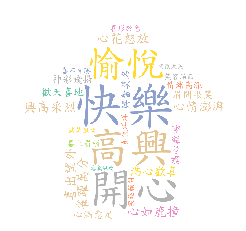

In [7]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 產生文字雲
def makeWordCloud(wordsList, colormap=None, mask=None, max_words=None):  
    if mask!=None:
        if mask=='round':
            x, y = np.ogrid[:300, :300]
            mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
            mask = 255 * mask.astype(int)
        else:
            mask = np.array(Image.open(mask))
    
    words = ' '.join(wordsList)
    wCloud = WordCloud(background_color = 'white', font_path = 'kaiu.ttf', max_words=max_words, colormap = colormap, mask = mask)
    wCloud.generate(words)
    wCloud.to_file('output.jpg')    
    plt.imshow(wCloud)
    plt.axis('off')
    plt.show()

# 實作：產生文字雲
wordsList=['快樂','開心','高興','愉悅','興高采烈','喜出望外','雀躍萬分','心如鹿撞','心花怒放','心情澎湃','滿心歡喜','歡天喜地','眉開眼笑','神彩飛揚','心滿意足','滿心歡暢','興奮莫名','情緒高漲','喜上眉梢','喜氣洋洋','喜形於色','喜不自勝','笑容滿面','笑逐顏開','談笑風生','開懷大笑','意氣風發']
makeWordCloud(wordsList,'Set2','./Day038_img/mask.png')

## 三、成果展示 (介紹成果的特點為何，並撰寫心得。)




In [8]:
board = 'HatePolitics'
all_article_info = []
previewpage = None # 沒有前一頁,表示最新文章頁面

# 取最新的6頁文章頁面
for i in range(0,6): 
    all_article_url,previewpage,nextpage = crawPTTboard(board,previewpage)
    print(i, ' ', previewpage, ' ', nextpage, '',len(all_article_url),'篇')

    # 取本頁面的所有文章資訊    
    for url_article in all_article_url:
        article_info = crawPTTarticle(url_article)
        all_article_info.append(article_info)

print('共取出',board, '版', len(all_article_info),'篇文章.')

0   4112   None  12 篇
1   4111   4113  20 篇
2   4110   4112  18 篇
3   4109   4111  17 篇
4   4108   4110  18 篇
5   4107   4109  20 篇
共取出 HatePolitics 版 105 篇文章.


In [9]:
# 對所有文章斷詞
all_lcutwords = []
for article_info in all_article_info:
    lcutwords = cutWords(article_info['content'])
    all_lcutwords.extend(lcutwords)

Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.353 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.344 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.373 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a

Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.367 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.359 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.375 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon

Loading model cost 1.383 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.345 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.330 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.344 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading

Loading model cost 1.424 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.390 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.354 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading model from cache C:\Users\Shannon\AppData\Local\Temp\jieba.u0d026fddda2d0a8d37cf2e1540dec150.cache
Loading model cost 1.350 seconds.
Prefix dict has been built successfully.
Building prefix dict from D:\!Shannon\ML100Days\crawler2\D38-D40\Day038_txt\dict.txt.big ...
Loading

In [10]:
print('斷詞數=', len(all_lcutwords))
# all_lcutwords

斷詞數= 46375


In [11]:
# 對所有斷詞提取字頻前50個關鍵字
keyWords = extractKeyWord(' '.join(all_lcutwords),50)
print('關鍵字=', len(keyWords))
keyWords

關鍵字= 50


['防疫',
 '中國',
 '美國',
 '柯文哲',
 '市長',
 '疫情',
 '旅館',
 '路線',
 '韓國瑜',
 '國家',
 '封城',
 '高雄',
 '文章',
 'imgur',
 '國民黨',
 '陸生',
 '公車',
 '25',
 '2020',
 '網址',
 'jpg',
 '確診',
 '總統',
 '口罩',
 '經濟',
 '蔡英文',
 '台北市',
 '內容',
 '台北',
 '超過',
 '中央',
 '民進黨',
 '網路',
 '蘇貞昌',
 '里長',
 '北韓',
 '政府',
 '臉書',
 '附註',
 '14',
 '之銘言',
 '542',
 '記者',
 '武漢',
 '板主',
 '隔離',
 '政治',
 '網友',
 '進行',
 '最後']

In [ ]:
# 前30文字雲
makeWordCloud(keyWords,'Dark2','round',30)

## 四、結論 (總結本次專題的問題與結果)

這次專題中出現許多課程中未出現過的模組，例如：文章斷詞、關鍵字提取、字頻分析．．．等等，這些模組似乎值得再開幾天課程好好討論，相信對專題產出的結果會更理想。

## 五、期末專題作者資訊 (請附上作者資訊)

1. 個人Github連結<br>
https://github.com/ML100Days/2nd-PyCrawlerMarathon<br><br>

2. 個人在百日馬拉松顯示名稱<br>
Melanie
